# Analyse: généralités

Tasks to be performed on flat runs:
* identify data path for run 13144
* display the 16 amplifiers of a sensor/raft
* overscan and bias correction
* gain correction
* display different illuminations

*******************

* Per set of data
    * Identify the biasses, and the level of illumination
* Per exposure / files / amps
   * open the file
   * correct for overscan and bias 
  
   

From P. Antilogus:
* /sps/lsst/users/antilog/web/bot/spot/Xtalk_Spot.ipynb
* bot_frame_op.py

From P. Astier:
* /sps/lsst/users/astier/slac/13144/gains.list 
* Cod.py

# NP (from P. Antilogus): Pour les données à differents flux : /sps/lsst/groups/FocalPlane/SLAC/run5/13144  c’est un run PTC
* le bas flux à des filtres neutres pour reduire le flux pour un temps de pose donnée … ci-joint la syntaxe des noms de directory :
  * flat_ND_OD0.5_SDSSi_492.0_flat0_351
      * ND_OD0.5: neutral density filter 0.5   ( l’autre solution : empty = pas de filtre )
      * SDSSi   : filtre SDSS i
      * 492.0   : flux de 492 e-   , le flux le plus bas est donné à 50e- …mais l’éclairement est non uniforme sur les bord c’est bien moins
      * flat0   : première pose d’une série de 2 ( il y aussi donc le flat1 )
      * 351     : 351 ieme pose du run

In [3]:
import astropy.io.fits as pyfits
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import matplotlib.cm as cm

## Task 1: open a sensor with 16 amplifiers and look to the raw data


In [4]:
#path='/sps/lsst/groups/FocalPlane/SLAC/run5/13144'

In [5]:
#open file of flat data, for one exposure, R22/S11
file_name = 'C:/Users/julie/OneDrive/Bureau/stage/MC_C_/MC_C_20211207_000048_R22_S11_000.fits' 

In [6]:
doss = os.listdir("C:/Users/julie/OneDrive/Bureau/stage/MC_C_")
data=(len(doss))

In [29]:
#open file of flat data, for one exposure, R22/S11
file=os.path.basename(file_name)
filesplit=os.path.splitext(file)
file=filesplit[0]

In [8]:
#ccd_exposure_1000=pyfits.open(file_name)

In [9]:
# Image plotting from P.A.
def plot_ccd_raw(ccd_exposure,contrast=250):
    h=list()
    for i in range(16):
        h.append(plt.hist(np.ravel(ccd_exposure[i+1].data),bins=100))

    #vmin=98000
    #vmax=102000
    window=contrast
    for i in range(16) :
    #    norm = ImageNormalize(fits[i+1].data[first_line:first_p_over,first_col:first_s_over], interval=PercentileInterval(70.))
        plt.subplot(2,8,i+1,title=i+1)
        #plt.imshow(fits[i+1].data[first_line:first_p_over,first_col:first_s_over],cmap = 'hot',origin='lower',norm=norm)

        center=(h[i][1][h[i][0].argmax()]+h[i][1][h[i][0].argmax()+1])/2
        vmin=center-window
        vmax=center+window

        plt.imshow(ccd_exposure[i+1].data,origin='lower',vmin=vmin,vmax=vmax)

        #print (np.mean(fits[i+1].data[first_line:first_p_over,first_col:first_s_over]) )
        if not(i%8 ==0) :
            figure=plt.gca()
            y_axis = figure.axes.get_yaxis()
            y_axis.set_visible(False)
        plt.colorbar()
    plt.show()

In [10]:
#récupère l'illumination à partir du nom du fichier
illum=[]
for nb in range (data) :
    file_name = 'C:/Users/julie/OneDrive/Bureau/stage/MC_C_/' + str (doss[nb]) 
    ccd_exposure_1000=pyfits.open(file_name)
    illu=file_name.split('_')
    illu=illu[8].split('.')
    illum.append(float(illu[0]))

In [37]:
def plot_edge(dossier, edge,illumination):
    fig, axs = plt.subplots(4,4,sharex=True,figsize=(18,9))
    begin=edge[1]
    end=edge[2]

    #axis : 0 suivant les colonnes et 1 suivant les lignes
    axis = edge[0]
    for nb in range (len(dossier)) :
        file_name = 'C:/Users/julie/OneDrive/Bureau/stage/MC_C_/' + str (dossier[nb]) 
        ccd_exposure=pyfits.open(file_name)
        
        
        i=0
        for ax in axs.flat:
            ax.plot(np.mean(ccd_exposure[i+1].data,axis=axis), label=illu[0],color=cm.viridis(illumination[nb]/np.max(illumination)))

            #limite des axes
            ax.set_xlim(begin,end)
            moyenne=np.mean(ccd_exposure[i+1].data)
            #ax.set_ylim(moyenne-20,moyenne+20)
            ax.set_ylim(24000,170000)
        

            #légendes
            ax.set_title('HDU '+str(i+1))
            #handles, labels = ax.get_legend_handles_labels()
            #fig.legend(handles, labels,bbox_to_anchor=(1.1, 1.0), loc='upper right',fontsize=14)
            ax.label_outer()
            #ax.set_xticks([0,1,2,3,4,5,6,7,8])
            i=i+1
            
            
        fig.subplots_adjust(right=0.9)
        cax = fig.add_axes([0.92, 0.1, 0.02, 0.8])  # [left, bottom, width, height]
        cmap = plt.cm.viridis
        norm = plt.Normalize(vmin=np.min(illumination), vmax=np.max(illumination))  
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
        sm.set_array([])  # nécessaire pour mettre à jour la colorbar correctement
        cbar = fig.colorbar(sm, cax=cax)
        cbar.set_label('Illuminations')
        fig.supylabel('mean signal (ADU)')
        fig.supxlabel('line index')
        #plt.savefig('HDU')

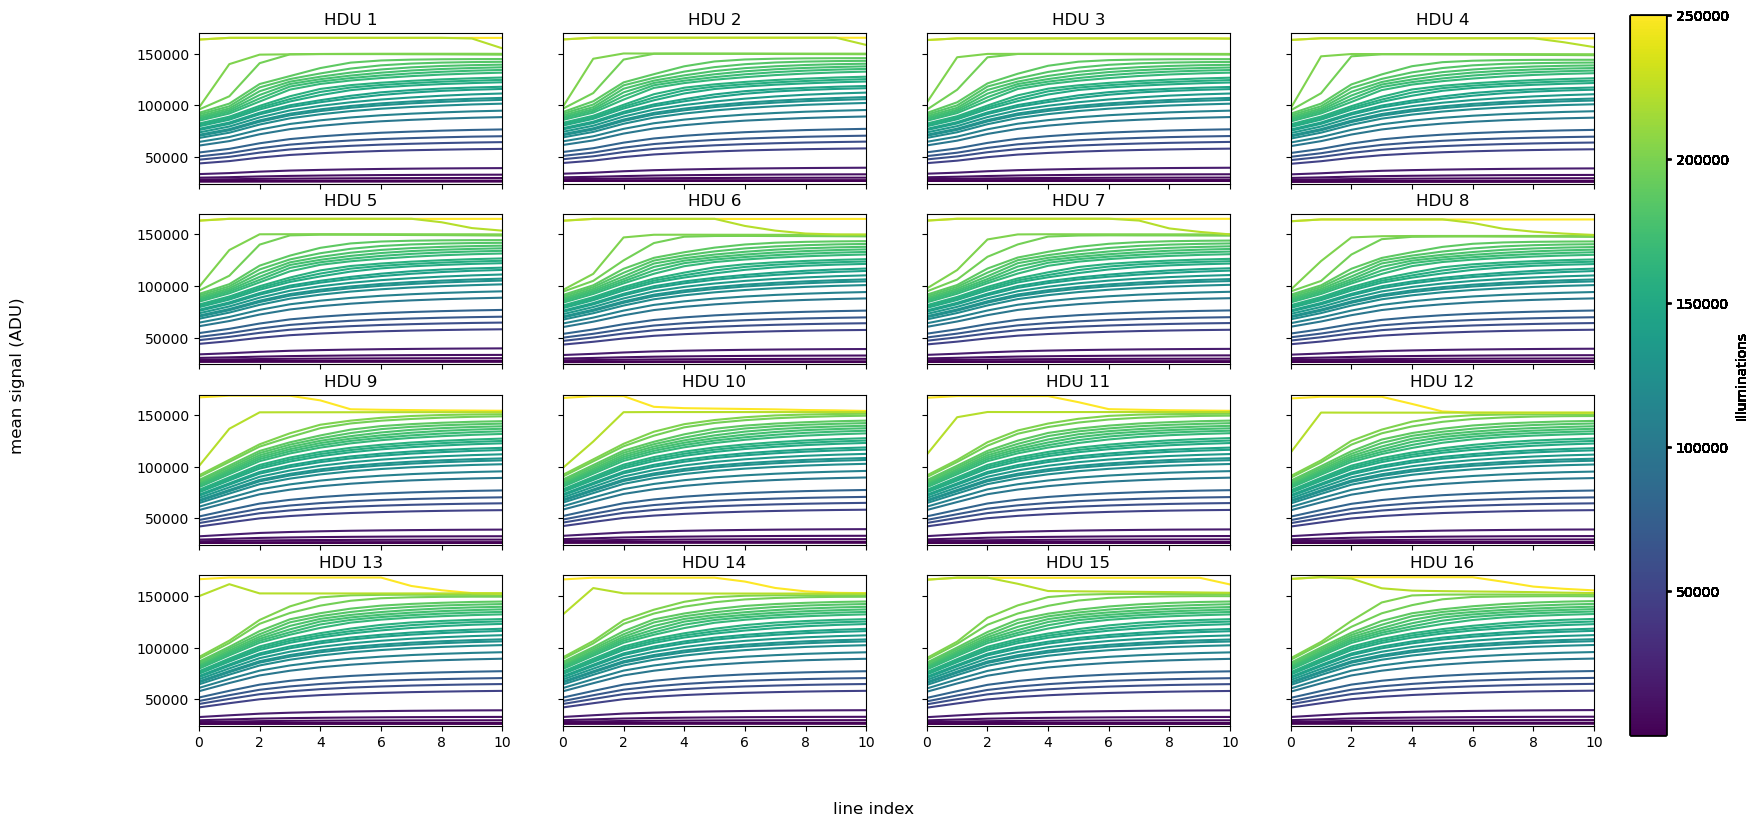

In [38]:
plot_edge(doss,(1,0,10),illum)

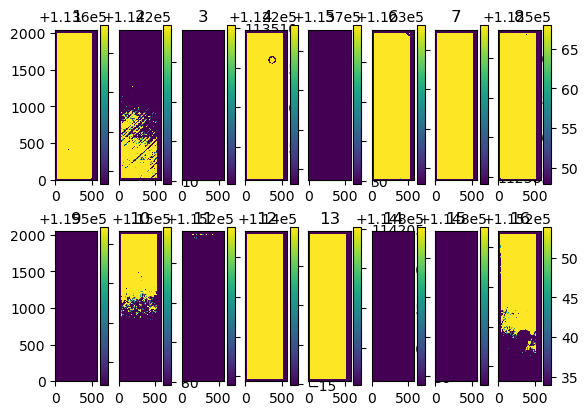

In [31]:
plot_ccd_raw(ccd_exposure_1000,contrast=10)

## Task 2: overscan subtraction on an exposure

Follow Xtalk_Spot recipee

In [11]:
%run -i  C:/Users/julie/OneDrive/Bureau/stage/bot_frame_op.py

In [12]:
# Method for Bias correction , for some spot you should use the 1D to avoid bleeding side effect
# We do 1D bias correction to avoid side effect of bleeding on 2D bias subtraction , for example for 
# the spot in amp hdu 3+1 , the amplifier 0+1 at hight flux as a uncorect bias subtraction due to bleeding 
# 1D bias subtraction will fix this ...
#UnBias='1D'
UnBias='2D'

In [13]:
def parse_section(section_string) :
    # input : a fits-like section string (as in DATASEC '[y0:y1,x0:x1]')
    # output :  image section coordinate to be used in python table:  ymin , ymax ,xmin, xmax
    #
    r=section_string[1:-1].split(',')
    x=list(map(int,r[0].split(':')))
    y=list(map(int,r[1].split(':')))
    # put into pythonic way
    if y[0]<=y[1]:
        y[0] = y[0]-1
    else:
        y[1] = y[1]-1
    if x[0]<=x[1]:
        x[0] = x[0]-1
    else:
        x[1] = x[1]-1
    
    return y[0],y[1],x[0],x[1]

In [14]:
def SingleImageIR(actfile,gains=None):#,first_col=first_col,first_cover=first_s_over,first_line=first_line,first_lover=first_p_over):
        # Display an IR2 image , with amplifiers set at the right place ...there is a DM version which does this better...
        # but here you are in stand alone 
        # the default associated to the image area (pre-overscan excluded) are for e2v IR2 files 
        # if gains is provided, gains are applied
        
#        FileUnBias.all_file[0].Datasec[0]
        # there are also these keywords in actfile, but boundary control is not the same...
        first_line,first_lover,first_col,first_cover=parse_section(actfile.Datasec[0])
        #first_col=actfile.first_col
        #first_cover=actfile.first_s_over
        #first_line=actfile.first_line
        #first_lover=actfile.first_p_over
        
        col_size=first_cover-first_col
        line_size=first_lover-first_line
        #
        spf=np.zeros((line_size*2,col_size*8))

        for i in range(16) :
            y1,y2,x1,x2=parse_section(actfile.Datasec[i])
            yd1,yd2,xd1,xd2=parse_section(actfile.Detsec[i])
            xdir,ydir=(1,1)
            if yd2<yd1:
                ydir=-1
                (yd2,yd1)=(yd1,yd2)
            if xd2<xd1:
                xdir=-1
                (xd2,xd1)=(xd1,xd2)
            if gains is not None:
                raft_ccd=actfile.raftbay+'_'+actfile.ccdslot
                amp='C'+actfile.Extname[i][-2:]
                #print (raft_ccd,amp,gains[raft_ccd][amp])
                spf[yd1:yd2,xd1:xd2]=actfile.Image[i][y1:y2,x1:x2][::ydir,::xdir] * gains[raft_ccd][amp]
            else:
                spf[yd1:yd2,xd1:xd2]=actfile.Image[i][y1:y2,x1:x2][::ydir,::xdir]
        return spf
                
        for i in range(16) :
            if i<8 :
                xx=i*col_size-1
                yy=0
                for x in range(first_col,first_cover) : 
                    #print(xx+col_size-(x-first_col))
                    spf[yy:yy+line_size,xx+col_size-(x-first_col)]=actfile.Image[i][first_line:first_lover,x]
            else :
                xx=(15-i)*col_size
                yy=-1
                for y in range(first_line,first_lover) :  
                    #print(yy+2*line_size-(y-first_line))
                    spf[yy+2*line_size-(y-first_line),xx:xx+col_size]=actfile.Image[i][y,first_col:first_cover]
                    
        return spf

In [15]:
file_list=[file_name]

In [16]:
# compute unbiased image
FileUnBias=InFile(dirall=file_list,Slow=False,verbose=False,Bias=UnBias) 

In [17]:
deoverscanned=SingleImageIR(FileUnBias.all_file[0])

In [18]:
def show_image_contrasted(image_data,contrast='auto'):
    med=np.median(image_data)
    if contrast=='auto':
        contrast = 1.5 * stats.iqr(image_data)
    plt.imshow(image_data,origin='lower',vmin=med-contrast,vmax=med+contrast)
    plt.colorbar()

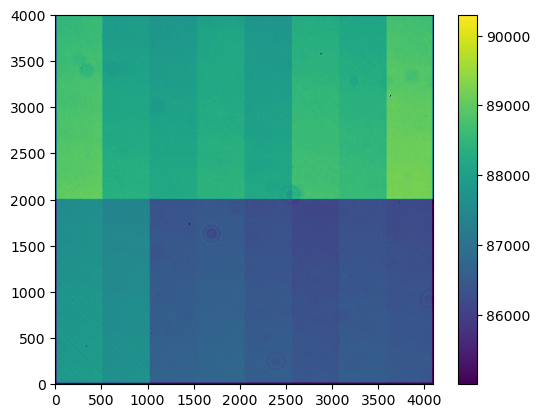

In [19]:
show_image_contrasted(deoverscanned)

In [20]:
moy_overscanned=np.mean(deoverscanned)

# Task 3 : apply the gains

In [21]:
import json

In [22]:
gains_file_name='13144_ptc_gains.json'

In [23]:
gains_file=open(gains_file_name)
gains=json.loads(gains_file.read())
gains_file.close()

In [24]:
gains['R22_S11']

{'C10': 1.4132808446884155,
 'C11': 1.419428825378418,
 'C12': 1.4361803531646729,
 'C13': 1.435083270072937,
 'C14': 1.43989896774292,
 'C15': 1.4436862468719482,
 'C16': 1.4402565956115723,
 'C17': 1.4393846988677979,
 'C07': 1.3957480192184448,
 'C06': 1.4069994688034058,
 'C05': 1.4050087928771973,
 'C04': 1.4126423597335815,
 'C03': 1.40752112865448,
 'C02': 1.4088630676269531,
 'C01': 1.4046446084976196,
 'C00': 1.3918954133987427}

In [25]:
for i,ext in enumerate(ccd_exposure_1000):
    if i>0:
        print(i,ext.header['EXTNAME'])

1 Segment10
2 Segment11
3 Segment12
4 Segment13
5 Segment14
6 Segment15
7 Segment16
8 Segment17
9 Segment07
10 Segment06
11 Segment05
12 Segment04
13 Segment03
14 Segment02
15 Segment01
16 Segment00
17 REB_COND
18 CONFIG_COND


In [26]:
#[k for k in FileUnBias.all_file[0].__dict__]

In [27]:
for i in range(16):
    debiassed=FileUnBias.all_file[0]
    raft_ccd=debiassed.raftbay+'_'+debiassed.ccdslot
    amp='C'+debiassed.Extname[i][-2:]
    print (raft_ccd,amp,gains[raft_ccd][amp])

R22_S11 C10 1.4132808446884155
R22_S11 C11 1.419428825378418
R22_S11 C12 1.4361803531646729
R22_S11 C13 1.435083270072937
R22_S11 C14 1.43989896774292
R22_S11 C15 1.4436862468719482
R22_S11 C16 1.4402565956115723
R22_S11 C17 1.4393846988677979
R22_S11 C07 1.3957480192184448
R22_S11 C06 1.4069994688034058
R22_S11 C05 1.4050087928771973
R22_S11 C04 1.4126423597335815
R22_S11 C03 1.40752112865448
R22_S11 C02 1.4088630676269531
R22_S11 C01 1.4046446084976196
R22_S11 C00 1.3918954133987427


#### Gains correction

In [28]:
deoverscanned_gain=SingleImageIR(FileUnBias.all_file[0],gains)

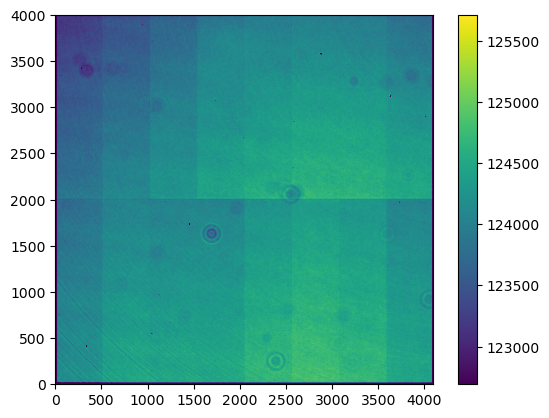

In [29]:
show_image_contrasted(deoverscanned_gain)

In [30]:
mean_deoverscanned_gain=np.mean(deoverscanned_gain)
print(mean_deoverscanned_gain)

123901.19733315473


In [31]:
with open("mean_deoverscanned_gain.txt", "w") as fichier:
    fichier.write('{0:9} {1:1} {2:1} {3:1} \n'.format(illu[0],str(doss[nb]),str(mean_deoverscanned_gain),str(moy_overscanned)))
fichier.close()